In [1]:
# keras module for building LSTM 
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras_preprocessing.text import Tokenizer
from keras.models import Sequential
import keras.utils as ku 
import keras_tuner as kt
# set seeds for reproducability

from numpy.random import seed

seed(1)

import pandas as pd
import numpy as np
import string, os 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.12.0
True


## Indlæs dataset

In [2]:

df = pd.read_csv('./data/Fake.csv')
df2 = pd.read_csv('./data/True.csv')
df.append(df2)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


# Data Preprocessing

In [3]:
df = df.drop(['title','subject','date'], axis=1)
df['text'] = df.sample(frac=1, random_state=1).values #Randomize the two dataframes
df = df.dropna(subset=['text'])
len(df.values)
print(df.isna())
print(df.values[:5])

        text
0      False
1      False
2      False
3      False
4      False
...      ...
23476  False
23477  False
23478  False
23479  False
23480  False

[23481 rows x 1 columns]
[['Here s what Politico s headline today looked like:Here s what the leftist anti-American rag Politico had to say about Angela Merkel s visit to the US to meet with our new President Donald Trump: This time the media hype surrounding a White House meeting is no wild exaggeration. When President Donald Trump and German Chancellor Angela Merkel finally get together on Friday, the leaders of the West s two most powerful countries are sure to come off more like an odd couple than two close allies chewing over plans for some joint enterprise. And for good reason. Merkel and Trump are not only polar opposites as people, but they share little in terms of international outlook.Their styles reflect their vastly different backgrounds. Merkel, Germany s first and only female chancellor, was raised by a pastor in comm

## Dataset preparation 

In [4]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in df.values]
corpus = corpus[:25]
corpus[:5]


['here s what politico s headline today looked like:here s what the leftist anti-american rag politico had to say about angela merkel s visit to the us to meet with our new president donald trump: this time the media hype surrounding a white house meeting is no wild exaggeration. when president donald trump and german chancellor angela merkel finally get together on friday, the leaders of the west s two most powerful countries are sure to come off more like an odd couple than two close allies chewing over plans for some joint enterprise. and for good reason. merkel and trump are not only polar opposites as people, but they share little in terms of international outlook.their styles reflect their vastly different backgrounds. merkel, germany s first and only female chancellor, was raised by a pastor in communist east germany, where she earned a doctorate in physical chemistry. although she is the longest-serving and most powerful leader in europe, she is unfailingly modest, competent an

In [5]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences_train, total_words_train = get_sequence_of_tokens(corpus)


print("train tokenized output:",inp_sequences_train[:10])
#pretty tabel visualized
inp_sequences_train[:10]

train tokenized output: [[94, 8], [94, 8, 21], [94, 8, 21, 610], [94, 8, 21, 610, 8], [94, 8, 21, 610, 8, 1020], [94, 8, 21, 610, 8, 1020, 611], [94, 8, 21, 610, 8, 1020, 611, 612], [94, 8, 21, 610, 8, 1020, 611, 612, 47], [94, 8, 21, 610, 8, 1020, 611, 612, 47, 94], [94, 8, 21, 610, 8, 1020, 611, 612, 47, 94, 8]]


[[94, 8],
 [94, 8, 21],
 [94, 8, 21, 610],
 [94, 8, 21, 610, 8],
 [94, 8, 21, 610, 8, 1020],
 [94, 8, 21, 610, 8, 1020, 611],
 [94, 8, 21, 610, 8, 1020, 611, 612],
 [94, 8, 21, 610, 8, 1020, 611, 612, 47],
 [94, 8, 21, 610, 8, 1020, 611, 612, 47, 94],
 [94, 8, 21, 610, 8, 1020, 611, 612, 47, 94, 8]]

In [6]:
def generate_padded_sequences(input_sequences,total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len



#### padded sekvens data


In [7]:
predictors_train, label_train, max_sequence_len_train = generate_padded_sequences(inp_sequences_train,total_words_train)
print(predictors_train.shape)

print(label_train.shape)
predictors_train[:10]


(9154, 983)
(9154, 2604)


array([[   0,    0,    0, ...,    0,    0,   94],
       [   0,    0,    0, ...,    0,   94,    8],
       [   0,    0,    0, ...,   94,    8,   21],
       ...,
       [   0,    0,    0, ..., 1020,  611,  612],
       [   0,    0,    0, ...,  611,  612,   47],
       [   0,    0,    0, ...,  612,   47,   94]], dtype=int32)

# Undersægelse på den rigtige Model

## Test af Model RNN

In [ ]:
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))

    model.add(SimpleRNN(hidden)) 
    model.add(Dropout(dropout))
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model

In [ ]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

In [ ]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

### Evaluering af Simple RNN

In [ ]:
print("Evaluate history from training")
print(history.history)

In [ ]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_x=model.predict(token_list) 
        predicted=np.argmax(predicted_x,axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

## Test af Model RNN med GRU

In [ ]:
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))

    model.add(GRUV2(hidden)) 
    model.add(Dropout(dropout)) 
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model

In [ ]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

In [ ]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

### Evaluering af Model med GRU

In [ ]:
print("Evaluate history from training")
print(history.history)

In [ ]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

## Test af Model RNN med LSTM

In [ ]:
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))
    model.add(LSTM(hidden)) 
    model.add(Dropout(dropout)) 
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model

In [ ]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

In [ ]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

### Evaluering af model med LSTM

In [ ]:
print("Evaluate history from training")
print(history.history)

In [ ]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

## Test af Model RNN med Bidirectional LSTM

In [ ]:
def create_model(max_sequence_len, total_words, lr, hidden,dropout):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 20, input_length=input_len))
    

    model.add(Bidirectional(LSTM(hidden)))
    model.add(Dropout(dropout))
    
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),  
    loss="categorical_crossentropy", 
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model

In [ ]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.001,hidden=100,dropout=0.15)
model.summary()

In [ ]:
epochs = 30
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

### Evaluering på model

In [ ]:
print("Evaluate history from training")
print(history.history)

In [ ]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))

# Den valgte Model RNN med Bidirectional LSTM

In [8]:
from tensorflow import keras
def create_model(max_sequence_len, total_words, lr, hidden,dropout,batch):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, batch, input_length=input_len))

    model.add(Bidirectional(LSTM(hidden)))

    model.add(Dropout(dropout)) # for at ungå overfitting
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(
     optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=[keras.metrics.CategoricalAccuracy(), 
    keras.metrics.MeanAbsoluteError()], 
    )
    
    return model



In [11]:
model = create_model(max_sequence_len_train, total_words_train,lr=0.01,hidden=100,dropout=0.15, batch=25)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 983, 25)           65100     
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              30400     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2604)              263004    
                                                                 
Total params: 358,504
Trainable params: 358,504
Non-trainable params: 0
_________________________________________________________________


# Træning af modellen

In [12]:
epochs = 60
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

Epoch 1/40
287/287 [==============================] - 53s 173ms/step - loss: 7.7669 - categorical_accuracy: 0.0393 - mean_absolute_error: 7.6246e-04
Epoch 2/40
287/287 [==============================] - 39s 135ms/step - loss: 6.7471 - categorical_accuracy: 0.0558 - mean_absolute_error: 7.5981e-04
Epoch 3/40
287/287 [==============================] - 28s 97ms/step - loss: 6.2695 - categorical_accuracy: 0.0688 - mean_absolute_error: 7.5259e-04
Epoch 4/40
287/287 [==============================] - 24s 84ms/step - loss: 5.7617 - categorical_accuracy: 0.1091 - mean_absolute_error: 7.3489e-04
Epoch 5/40
287/287 [==============================] - 21s 74ms/step - loss: 5.1662 - categorical_accuracy: 0.1502 - mean_absolute_error: 7.1162e-04
Epoch 6/40
287/287 [==============================] - 23s 79ms/step - loss: 4.5592 - categorical_accuracy: 0.1951 - mean_absolute_error: 6.8567e-04
Epoch 7/40
287/287 [==============================] - 21s 74ms/step - loss: 4.0336 - categorical_accuracy: 0.2

### Tuning hyper parametre

In [9]:
def build_model(hp):
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.3, step=0.05)
    hidden = hp.Int("hidden", min_value=50, max_value=300, step=50)
    batch = hp.Int("batch", min_value=10, max_value=50, step=5)
    lr = hp.Float("lr", min_value=0.0001, max_value=0.1, sampling="log")
    
    bmodel = create_model(
        max_sequence_len_train, total_words_train, lr=lr, hidden=hidden, dropout=dropout, batch=batch
    )
    return bmodel


build_model(kt.HyperParameters())
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="categorical_accuracy",
    max_trials=4, # more trails = better result
    executions_per_trial=1,
    overwrite=True,
    directory="data",
    project_name="hyperparamoptim",
)
tuner.search_space_summary()
tuner.search(predictors_train, label_train, epochs=4)
tuner.results_summary()


Trial 4 Complete [00h 03m 26s]
categorical_accuracy: 0.0381254106760025

Best categorical_accuracy So Far: 0.1367708146572113
Total elapsed time: 00h 14m 14s
Results summary
Results in data/hyperparamoptim
Showing 10 best trials
Objective(name="categorical_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
dropout: 0.15000000000000002
hidden: 50
batch: 25
lr: 0.022357867278396774
Score: 0.1367708146572113

Trial 0 summary
Hyperparameters:
dropout: 0.2
hidden: 250
batch: 45
lr: 0.002040732098533833
Score: 0.07537688314914703

Trial 1 summary
Hyperparameters:
dropout: 0.2
hidden: 150
batch: 20
lr: 0.00013204884424632683
Score: 0.05188988521695137

Trial 3 summary
Hyperparameters:
dropout: 0.25
hidden: 150
batch: 50
lr: 0.007289444455577516
Score: 0.0381254106760025


In [10]:
best_hps = tuner.get_best_hyperparameters()[0]
learning_rate = tuner.get_best_hyperparameters()[0]['lr']
dropout_rate = tuner.get_best_hyperparameters()[0]['dropout']
hidden = tuner.get_best_hyperparameters()[0]['hidden']
batch = tuner.get_best_hyperparameters()[0]['batch']
print(best_hps.values)


{'dropout': 0.15000000000000002, 'hidden': 50, 'batch': 25, 'lr': 0.022357867278396774}


In [ ]:
model = create_model(max_sequence_len_train, total_words_train,lr=learning_rate,hidden=hidden,dropout=dropout_rate, batch=batch)
model.summary()

In [ ]:
epochs = 100
history =model.fit(predictors_train, label_train, epochs=epochs, verbose=1)

In [13]:
model.save("data/trainedmodel")

# Evaluating af modellen

In [14]:
print("Evaluate history from training")
print(history.history)

Evaluate history from training
{'loss': [7.766898155212402, 6.747143745422363, 6.2695417404174805, 5.7617340087890625, 5.1662211418151855, 4.559170722961426, 4.033590316772461, 3.5714240074157715, 3.212372064590454, 2.957368850708008, 2.7272799015045166, 2.5340182781219482, 2.3912744522094727, 2.235455274581909, 2.1499369144439697, 2.0989387035369873, 2.026120901107788, 1.9715054035186768, 1.9652503728866577, 1.962632656097412, 1.9394093751907349, 1.8590967655181885, 1.8426268100738525, 1.8386561870574951, 1.84731125831604, 1.8555197715759277, 1.8076958656311035, 1.7544580698013306, 1.8456939458847046, 1.8148512840270996, 1.7685651779174805, 1.7971829175949097, 1.9542299509048462, 1.891629934310913, 1.8196003437042236, 1.8401163816452026, 1.9093760251998901, 1.8784421682357788, 1.8095840215682983, 1.7785000801086426], 'categorical_accuracy': [0.039327070116996765, 0.05582259222865105, 0.06882237643003464, 0.10913261771202087, 0.15020756423473358, 0.19510596990585327, 0.2354162186384201

[7.76689816 6.74714375 6.26954174 5.76173401 5.16622114 4.55917072
 4.03359032 3.57142401 3.21237206 2.95736885 2.7272799  2.53401828
 2.39127445 2.23545527 2.14993691 2.0989387  2.0261209  1.9715054
 1.96525037 1.96263266 1.93940938 1.85909677 1.84262681 1.83865619
 1.84731126 1.85551977 1.80769587 1.75445807 1.84569395 1.81485128
 1.76856518 1.79718292 1.95422995 1.89162993 1.81960034 1.84011638
 1.90937603 1.87844217 1.80958402 1.77850008]


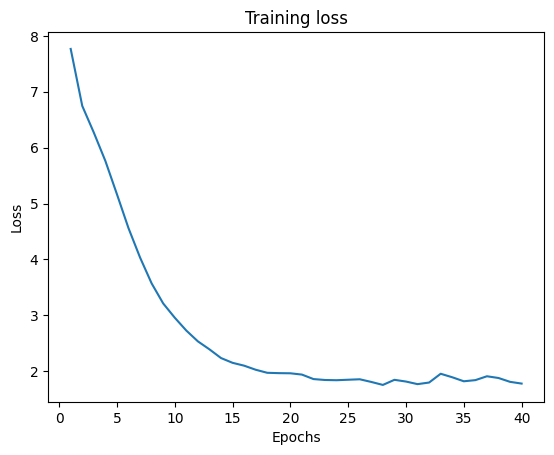

In [15]:
loss_train =  np.array(history.history['loss'])
epochs = range(1,epochs+1)
print(loss_train)
plt.plot(epochs,loss_train)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

range(1, 41)
[0.03932707 0.05582259 0.06882238 0.10913262 0.15020756 0.19510597
 0.23541622 0.27802053 0.32051563 0.35973346 0.37950623 0.41588378
 0.44330347 0.46657199 0.48372295 0.49421018 0.5037142  0.51704174
 0.51693249 0.51857114 0.52097446 0.53725147 0.5347389  0.54151189
 0.54271358 0.54238582 0.55057901 0.56445271 0.54599082 0.54631853
 0.55145293 0.5556041  0.52305001 0.5347389  0.54304129 0.5399825
 0.53189862 0.54183966 0.5571335  0.55331004]


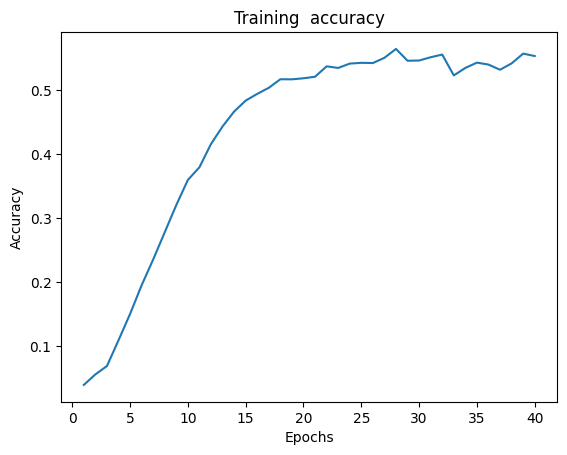

In [16]:
acc_train = np.array(history.history['categorical_accuracy'])
print(epochs)
print(acc_train)
plt.plot(epochs,acc_train)
plt.title('Training  accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [17]:
#model = tf.keras.models.load_model('data/trainedmodel')

# Generator for tekst


In [18]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_x=model.predict(token_list) 
        predicted=np.argmax(predicted_x,axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

### Generate text

In [19]:
print (generate_text("united states is a", 20, model, max_sequence_len_train))


1/1 [==============================] - 0s 37ms/step
United States Is A Priority In This Is What Many It S Part Because Of The Values From The Official Federal The Homeland Under
